# About

The purpose of this notebook is to provide an example of how standard DICOM objects containing annotations and evaluations of the nodules for the TCIA [LIDC-IDRI](https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI) collection, as presented in the following article, can be used from Python.

> Fedorov A, Hancock M, Clunie D, Brochhausen M, Bona J, Kirby J, Freymann J, Pieper S, Aerts H, Kikinis R, Prior F. 2018. Standardized representation of the LIDC annotations using DICOM. PeerJ Preprints 6:e27378v1 https://doi.org/10.7287/peerj.preprints.27378

Another goal of this notebook is to validate the accuracy of the conversion from the `pylidc` representation.

## Prerequisites

This notebook assumes you have the following locally on your computer:
* Images from the TCIA LIDC-IDRI collection, see download instructions here: https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI
* DICOM Segmentations and Structured Reporting objects (at the time of writing this, those are located separately from the images), see download instructions here: https://wiki.cancerimagingarchive.net/display/DOI/Standardized+representation+of+the+TCIA+LIDC-IDRI+annotations+using+DICOM


## Conversion consistency verification approach

Conversion verification is done by confirming that:
* each of the nodules larger than 3 mm, as queried from `pylidc`, is also encoded in DICOM;
* there is only one DICOM SEG and one DICOM SR object corresponding to a single annotation of a nodule in the DICOM dataset;
* quantitative and qualitative assessment values are consistent between the two representations.

Verification consists of evaluating two components of the dataset metadata (evaluations, measurements, referenced images) and pixel data (voxels labeled as belonging to a certain nodule).

In order to support this verification, the data first needs to be prepared for consuming it from python. Although there can be various ways to do this, our approach will utilize the following steps:

TODO: clarify sorting is optional! explain tables building can be incremental!

1. DICOM files are first organized using [dicomsort](https://github.com/pieper/dicomsort):

`python dicomsort.py <location of DICOM images, SEG and SR files> \
  <directory to store sorted files>/%PatientID/%StudyInstanceUID/%SeriesInstanceUID-%SeriesNumber-%Modality/%SOPInstanceUID.dcm`

2. Extract DICOM metadata into tabular form using [dcm2tables](https://github.com/QIICR/dcm2tables). The result is a set of tables that are defined by [this schema](https://app.quickdatabasediagrams.com/#/d/K6UbDf).

`python tabulate.py -s schema.qdbd -d <directory with the sorted files> -o <directory to store metadata tables>`

In [11]:
import pylidc as pl
import pandas as pd
import os, json

CT_DICOM_PATH = "/Users/fedorov/Documents/TCIA/LIDC-IDRI"
CT_TABLES_PATH = "/Users/fedorov/Documents/TCIA/LIDC-IDRI-tables"

DERIVED_DICOM_PATH = "/Users/fedorov/Temp/LIDC_conversion2"
DERIVED_TABLES_PATH = "/Users/fedorov/Temp/LIDC_conversion2-tables"

In [12]:
# read CT DICOM metadata tables
imagesTablesNames = [
                # one per DICOM file, attributes that are available in every DICOM object
               'CompositeContext',
    
                # modality-specific attributes
               'CT',
    
               # pointer from the DICOM SOPInstanceUID to the file on the filesystem
               'Instance2File'                     
              ]
imagesTables = {}
for t in imagesTablesNames:
    imagesTables[t]=pd.read_csv(os.path.join(CT_TABLES_PATH,t+'.tsv'), sep='\t', dtype=str, low_memory=False)

In [13]:
for t in imagesTablesNames:
  imagesTables[t].to_csv(sep="\t", path_or_buf="/Users/fedorov/Temp/"+t+".tsv")

In [14]:
# read derived DICOM metadata tables
derivedTablesNames = [
               # one per DICOM file, attributes that are available in every DICOM object
               'CompositeContext',
    
               # when applicable, references to related DICOM objects in the derived datasets
               'References', 
    
               # modality-specific attributes
               'SEG','SR',
    
               # attributes specific to DICOM Segmentations; each Segmentation
               # object contains one or more segment, and each segment contains
               # one or more frame (i.e., "slice") with the labeled pixels
               'SEG_Segments','SEG_SegmentFrames',
    
               # attributes specific to DICOM Structured Reports (SR)
               'SR1500_Measurements','SR1500_MeasurementGroups', 
    
               # qualitative assessments  
               'SR1500_QualitativeEvaluations',     
    
               # pointer from the DICOM SOPInstanceUID to the file on the filesystem
               'Instance2File'        
              ]
derivedTables = {}
for t in derivedTablesNames:
    derivedTables[t]=pd.read_csv(os.path.join(DERIVED_TABLES_PATH,t+'.tsv'), sep='\t', dtype=str, low_memory=False)

In [15]:
derivedTables["SEG_Segments"]

,AnatomicRegionSequence_CodeMeaning,AnatomicRegionSequence_CodeValue,AnatomicRegionSequence_CodingSchemeDesignator,SOPInstanceUID,SegmentAlgorithmName,SegmentAlgorithmType,SegmentLabel,SegmentNumber,SegmentedPropertyCategoryCodeSequence_CodeMeaning,SegmentedPropertyCategoryCodeSequence_CodeValue,SegmentedPropertyCategoryCodeSequence_CodingSchemeDesignator,SegmentedPropertyTypeCodeSequence_CodeMeaning,SegmentedPropertyTypeCodeSequence_CodeValue,SegmentedPropertyTypeCodeSequence_CodingSchemeDesignator
0,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.49901.1552686540.119556,NaN,MANUAL,Nodule 1 - Annotation IL057_123070,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
1,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.49905.1552686547.559794,NaN,MANUAL,Nodule 1 - Annotation 0,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
2,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.49899.1552686536.195712,NaN,MANUAL,Nodule 1 - Annotation Nodule 001,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
3,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.49911.1552686559.140693,NaN,MANUAL,Nodule 2 - Annotation MI014_11887,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
4,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.49913.1552686562.894798,NaN,MANUAL,Nodule 2 - Annotation 3,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
5,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.49903.1552686543.783060,NaN,MANUAL,Nodule 1 - Annotation MI014_11888,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
6,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.49907.1552686551.632852,NaN,MANUAL,Nodule 2 - Annotation Nodule 002,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
7,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.49915.1552686566.809760,NaN,MANUAL,Nodule 3 - Annotation Nodule 004,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
8,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.49909.1552686555.292594,NaN,MANUAL,Nodule 2 - Annotation IL057_123066,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT
9,Lung,T-28000,SRT,1.2.276.0.7230010.3.1.4.0.49749.1552686380.683508,NaN,MANUAL,Nodule 1 - Annotation 8,1,Morphological Abnormal Structure,M-01000,SRT,Nodule,M-03010,SRT


In [25]:
# load dictionaries
    
conceptsDictionary = {}
valuesDictionary = {}
with open("../concepts_dict.json") as cf:
  conceptsDictionary = json.load(cf)
with open("../values_dict.json") as vf:
  valuesDictionary = json.load(vf)

In [59]:
subjectsToVerify = [("LIDC-IDRI-%04i" % i) for i in range(1,11)]

# iterate over data, confirm existence of data, 
# one SEG and one SR per annotation, and consistency of numeric
# and qualitative assessment values between pylidc and DICOM representation
from decimal import *
epsilon = 1e-2

def compareNumbers(v1, v2):
  assert (abs(v1-v2) < epsilon), "Comparison threshold exceeded: %f vs %f!" % (v1, v2) 

def compareStrings(s1, s2):
  assert (s1 == s2), "Comparison strings failed: %s vs %s!" % (s1, s2) 

def compareCodes(c1, c2):
  assert (c1["CodeValue"] == c2["CodeValue"]), "CodeValue mismatch"
  assert (c1["CodeMeaning"] == c2["CodeMeaning"]), "CodeMeaning mismatch"
  assert (c1["CodingSchemeDesignator"] == c2["CodingSchemeDesignator"]), "CodingSchemeDesignator mismatch"

for s in subjectsToVerify:
  print(s)
  scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == s)
  for scan in scans:
    studyUID = scan.study_instance_uid
    seriesUID = scan.series_instance_uid
    ctSeriesDir = os.path.join(CT_DICOM_PATH,s,studyUID,seriesUID)
    derivedSeriesDir = os.path.join(DERIVED_DICOM_PATH, s, studyUID, seriesUID)
    
    referencesSubset = derivedTables["References"][derivedTables["References"]["ReferencedSeriesInstanceUID"] == seriesUID]
    referencingUIDs = pd.unique(referencesSubset["SOPInstanceUID"])
    thoseReferenceSeries = derivedTables["CompositeContext"][derivedTables["CompositeContext"]["SOPInstanceUID"].isin(referencingUIDs)]
    
    segmentations = thoseReferenceSeries[thoseReferenceSeries["Modality"]=="SEG"]
    segmentsSubset = derivedTables["SEG_Segments"][derivedTables["SEG_Segments"]["SOPInstanceUID"].isin(referencingUIDs)]
    segments = pd.merge(segmentsSubset, segmentations, on=["SOPInstanceUID"])
        
        
    #if s == "LIDC-IDRI-0010":
    #  showSubjectInSlicer(ctSeriesDir, derivedSeriesDir, seriesDescriptionPrefix="Nodule 3")        
    
    #print(segments["SegmentLabel"])
    
    for nCount,nodule in enumerate(scan.cluster_annotations()):
      for aCount,a in enumerate(nodule):
        
        # this is the convention used to name segments (SegmentDescription and SegmentLabel)
        segmentLabel = "Nodule "+str(nCount+1) +" - Annotation " + a._nodule_id
        print("   > "+segmentLabel)
        # Find corresponding segment:
        #  1. find SEGs that reference the SeriesInstanceUID of the CT annotated
        #  2. find the specific SEG using SegmentLabel
        #  3. if there are multiple annotations that have the same ID, we are screwed
        segment = segments[segments["SegmentLabel"] == segmentLabel]
        if segment.shape[0] != 1:
          print("Not 1 matching segment for %s: %i!" % (segmentLabel,segment.shape[0]))
          continue
        #print(str(segment["SOPInstanceUID"].values))
        
        segmentationInstanceUID = segment["SOPInstanceUID"].values[0]
        
        # now get measurement groups that correspond to those Structured Reports instances
        # For the specific dataset, we know there is a single measurement group per segment,
        #  and we also know there is a single segment per segmentation, so this makes life easier
        measurementGroups = derivedTables["SR1500_MeasurementGroups"][derivedTables["SR1500_MeasurementGroups"]["segmentationSOPInstanceUID"] == segmentationInstanceUID]
        assert (measurementGroups.shape[0] == 1), "Not one measurement group per segment: %i!" % measurementGroupsSubset.shape[0]
        structuredReportUID = measurementGroups["SOPInstanceUID"].values[0]
        
        qualEval = derivedTables["SR1500_QualitativeEvaluations"][derivedTables["SR1500_QualitativeEvaluations"]["SOPInstanceUID"] == structuredReportUID]
        quantEval = derivedTables["SR1500_Measurements"][derivedTables["SR1500_Measurements"]["SOPInstanceUID"] == structuredReportUID]        
        
        # check quantitative measurements
        assert (len(quantEval[quantEval["quantity_CodeMeaning"]=="Volume"]["value"].values) == 1), "Number of measurements is not one!"
        assert (len(quantEval[quantEval["quantity_CodeMeaning"]=="Diameter"]["value"].values) == 1), "Number of measurements is not one!"
        assert (len(quantEval[quantEval["quantity_CodeMeaning"]=="Surface area of mesh"]["value"].values) == 1), "Number of measurements is not one!"

        dcmVolume = quantEval[quantEval["quantity_CodeMeaning"]=="Volume"]["value"].values[0]
        dcmDiameter = quantEval[quantEval["quantity_CodeMeaning"]=="Diameter"]["value"].values[0]
        dcmSurface = quantEval[quantEval["quantity_CodeMeaning"]=="Surface area of mesh"]["value"].values[0]
        
        compareStrings(dcmVolume,  ("%E" % Decimal(a.volume)))
        compareStrings(dcmDiameter, ("%E" % Decimal(a.diameter)))
        compareStrings(dcmSurface, ("%E" % Decimal(a.surface_area)))
            
        dcmStr = quantEval[quantEval["quantity_CodeMeaning"]=="Volume"]["value"].values[0]
        
        # check code values
        for attribute in conceptsDictionary.keys():
          aItem = {}

          if attribute == "internalStructure" and segmentLabel == "Nodule 8 - Annotation 1708" and s == "LIDC-IDRI-0510":
            #print("  Skipping knowingly faulty item")
            continue
        
          try:
            aItem["conceptCode"] = conceptsDictionary[attribute]
            aItem["conceptValue"] = valuesDictionary[attribute][str(getattr(a, attribute))]
          
          except KeyError:            
            print(" Invalid attribute: "+attribute+': '+str(getattr(a, attribute))+" "+segmentLabel)
            
          if qualEval[qualEval["conceptCode_CodeMeaning"]==aItem["conceptCode"]["CodeMeaning"]].shape[0] != 1:
            print("  Failed to find quantitative assessment for %s in DICOM representation" % aItem["conceptCode"]["CodeMeaning"])
            continue

          #print(qualEval["conceptValue_CodeMeaning"])
          dcmItem = qualEval[qualEval["conceptCode_CodeMeaning"]==aItem["conceptCode"]["CodeMeaning"]]
          compareCodes(aItem["conceptValue"], {"CodeValue": dcmItem["conceptValue_CodeValue"].values[0], \
                                               "CodeMeaning": dcmItem["conceptValue_CodeMeaning"].values[0], \
                                               "CodingSchemeDesignator": dcmItem["conceptValue_CodingSchemeDesignator"].values[0]})
        

        
#      break
#    break
#  break

LIDC-IDRI-0001
   > Nodule 1 - Annotation Nodule 001
   > Nodule 1 - Annotation IL057_127364
   > Nodule 1 - Annotation MI014_12127
   > Nodule 1 - Annotation 0
LIDC-IDRI-0002
   > Nodule 1 - Annotation MI014_11691
   > Nodule 1 - Annotation 8
LIDC-IDRI-0003
   > Nodule 1 - Annotation 12
   > Nodule 2 - Annotation Nodule 001
   > Nodule 2 - Annotation IL057_130591
   > Nodule 2 - Annotation MI014_16588
   > Nodule 2 - Annotation 0
   > Nodule 3 - Annotation Nodule 003
   > Nodule 3 - Annotation IL057_130602
   > Nodule 3 - Annotation MI014_16599
   > Nodule 3 - Annotation 8
   > Nodule 4 - Annotation Nodule 002
   > Nodule 4 - Annotation IL057_130598
   > Nodule 4 - Annotation MI014_16595
   > Nodule 4 - Annotation 9
LIDC-IDRI-0004
   > Nodule 1 - Annotation Nodule 001
   > Nodule 1 - Annotation IL057_132683
   > Nodule 1 - Annotation MI014_16178
   > Nodule 1 - Annotation 0
LIDC-IDRI-0005
   > Nodule 1 - Annotation Nodule 001
   > Nodule 1 - Annotation IL057_123070
   > Nodule 1 - Ann

## Visualize specific annotation

In [49]:
import tempfile, subprocess
slicerAppBinary = "/Applications/Slicer.app/Contents/MacOS/Slicer"

def showSubjectInSlicer(ctDICOMDir, derivedDICOMDir, srSeriesUID=None, seriesDescriptionPrefix=None):
  # read the template startup script
  # populate directories placeholders
  # ctDICOMDir, derivedDICOMDir
  templateScriptFile = "../slicerLoaderTemplate.py"
  templateScript = open(templateScriptFile, 'r').read()
  templateScript = templateScript.replace("<CT_DICOM_PATH_PLACEHOLDER>", ctDICOMDir)
  templateScript = templateScript.replace("<DERIVED_DICOM_PATH_PLACEHOLDER>", derivedDICOMDir)

  if srSeriesUID is not None:
    templateScript = templateScript.replace("<SR_SERIES_UID_PLACEHOLDER>", "\""+srSeriesUID+"\"")
  else:
    templateScript = templateScript.replace("<SR_SERIES_UID_PLACEHOLDER>", "None")

  if seriesDescriptionPrefix is not None:
    templateScript = templateScript.replace("<SERIES_DESCRIPTION_PREFIX_PLACEHOLDER>", "\""+seriesDescriptionPrefix+"\"")
  else:
    templateScript = templateScript.replace("<SERIES_DESCRIPTION_PREFIX_PLACEHOLDER>", "None")    
    
  tmpfile = tempfile.mktemp()+".py"
  startupScriptFile = open(tmpfile, "w")
  startupScriptFile.write(templateScript)
  startupScriptFile.close()
  print("Written content to "+tmpfile)
    
  slicerCmd = [slicerAppBinary, "--python-script", tmpfile]
  sp = subprocess.Popen(slicerCmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  sp.wait()
  (stdout,stderr) = sp.communicate() 
  print(stdout)
  print(stderr)

In [100]:
def getPylidcAnnotationByLabel(subjectID, segmentLabel):
  result = None
  scans = pl.query(pl.Scan).filter(pl.Scan.patient_id == subjectID)
  for scan in scans:
    for nCount,nodule in enumerate(scan.cluster_annotations()):
      for aCount,a in enumerate(nodule):
        label = "Nodule "+str(nCount+1) +" - Annotation " + a._nodule_id
        if label == segmentLabel:
          result = a
  return result

def getCTSEGSRSeriesUIDsForSegment(subjectID, segmentLabel):
  # showSubjectInSlicer(ctDICOMDir, derivedDICOMDir, srSeriesUID=None, seriesDescriptionPrefix=None):
  # first, find that subject in the 

  ctSeriesUID = None
  segSeriesUID = None
  srSeriesUID = None
  studyUID = None

  segment = derivedTables["SEG_Segments"][derivedTables["SEG_Segments"]["SegmentLabel"] == segmentLabel]
  segment = pd.merge(segment,derivedTables["CompositeContext"], on=["SOPInstanceUID"])

  assert (segment.shape[0] == 1), "Not 1 matching segment for %s: %i!" % (segmentLabel,segment.shape[0]) 

  segSeriesUID = segment["SeriesInstanceUID"].values[0]
  segInstanceUID = segment["SOPInstanceUID"].values[0]

  # we know each segmentation references one and only one CT series
  ctSeriesUID = derivedTables["References"][derivedTables["References"]["SOPInstanceUID"]==segInstanceUID]["ReferencedSeriesInstanceUID"].values[0]
        
  # now get measurement groups that correspond to those Structured Reports instances
  # For the specific dataset, we know there is a single measurement group per segment,
  #  and we also know there is a single segment per segmentation, so this makes life easier
  measurementGroups = derivedTables["SR1500_MeasurementGroups"][derivedTables["SR1500_MeasurementGroups"]["segmentationSOPInstanceUID"] == segInstanceUID]
  measurementGroups = pd.merge(measurementGroups, derivedTables["CompositeContext"], on=["SOPInstanceUID"])
  assert (measurementGroups.shape[0] == 1), "Not one measurement group per segment: %i!" % measurementGroupsSubset.shape[0]
  srSeriesUID = measurementGroups["SeriesInstanceUID"].values[0]
  studyUID = measurementGroups["StudyInstanceUID"].values[0]
    
  return (studyUID, ctSeriesUID, segSeriesUID, srSeriesUID)

### pylidc

Loading dicom files ... This may take a moment.


<IPython.core.display.Javascript object>


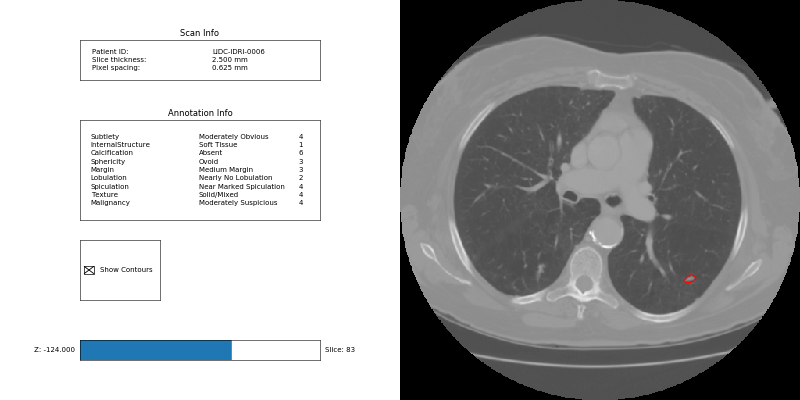

In [104]:
%matplotlib notebook
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 50

subject = "LIDC-IDRI-0005"
annotationLabel = "Nodule 2 - Annotation MI014_11887"

subject = "LIDC-IDRI-0006"
annotationLabel = "Nodule 4 - Annotation IL057_127062"

a = getPylidcAnnotationByLabel(subject, annotationLabel)

a.visualize_in_scan()



### 3D Slicer

In [105]:
(studyUID, ctUID, segUID, srUID) = getCTSEGSRSeriesUIDsForSegment(subject, annotationLabel)

ctDICOMDir = os.path.join(CT_DICOM_PATH, subject, studyUID, ctUID)
derivedDICOMDir = os.path.join(DERIVED_DICOM_PATH, subject, studyUID)

showSubjectInSlicer(ctDICOMDir, derivedDICOMDir, srUID)

Written content to /var/folders/sk/vymvzt3s7px3y5lkm9td9bxc0000gn/T/tmpg50x_5m0.py


NameError: name 'stdour' is not defined